# Configuration
* packages
* data accessing credentials


In [48]:
import pandas as pd

import requests
from urllib.request import urlopen 
from urllib.parse import quote  

import time
import json

import datetime as dt

from concurrent.futures import ThreadPoolExecutor

import nltk

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

import ast

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sddk

In [3]:
# spatial packages
import googlemaps
import shapely # geometries, e.g. "POINT (23931.23 45492.17)"
import geopandas # pandas DataFrame + geometry
import contextily as ctx # basemaps

In [4]:
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [5]:
# read personal google api key stored on sciencedata
key = sddk.read_file("Google_API_key.txt", "str", conf)
gmaps = googlemaps.Client(key=key)

# Merging scraped data files

In [49]:
# sciencedata folder containing our data
sciencedata_folder = "instagram_webscraping"

# what data files we have
sorted_file_numbers = sorted([int(fn.rpartition("_")[2].partition(".")[0]) for fn in sddk.list_filenames("instagram_webscraping", "", conf) if "posts_raw" in fn])
sorted_filenames = ["posts_raw_" + str(num) + ".json" for num in sorted_file_numbers]
print(sorted_filenames)

['posts_raw_50.json', 'posts_raw_100.json', 'posts_raw_150.json', 'posts_raw_200.json', 'posts_raw_250.json', 'posts_raw_300.json', 'posts_raw_350.json', 'posts_raw_400.json', 'posts_raw_450.json', 'posts_raw_500.json', 'posts_raw_550.json', 'posts_raw_600.json', 'posts_raw_650.json', 'posts_raw_700.json', 'posts_raw_750.json', 'posts_raw_800.json', 'posts_raw_850.json', 'posts_raw_900.json', 'posts_raw_950.json', 'posts_raw_1000.json', 'posts_raw_1050.json', 'posts_raw_1100.json', 'posts_raw_1150.json', 'posts_raw_1200.json', 'posts_raw_1250.json', 'posts_raw_1300.json', 'posts_raw_1350.json', 'posts_raw_1400.json', 'posts_raw_1450.json', 'posts_raw_1500.json', 'posts_raw_1550.json', 'posts_raw_1600.json', 'posts_raw_1650.json', 'posts_raw_1700.json', 'posts_raw_1750.json', 'posts_raw_1800.json', 'posts_raw_1850.json', 'posts_raw_1900.json', 'posts_raw_1950.json', 'posts_raw_2000.json', 'posts_raw_2050.json', 'posts_raw_2100.json', 'posts_raw_2150.json', 'posts_raw_2200.json', 'posts_

In [50]:
%%time
# measure cell execution time


# open the first datafile
posts = sddk.read_file("instagram_webscraping" + "/" + sorted_filenames[0], "df", conf)
# append the remaining files to it:
for filename in sorted_filenames[1:]:
    actual_df = sddk.read_file("instagram_webscraping" + "/" + filename, "df", conf)
    posts = pd.concat([posts, actual_df])
# how many posts we have?
len(posts)

CPU times: user 17 s, sys: 3.31 s, total: 20.3 s
Wall time: 1min 11s


240561

In [52]:
posts.head(5)

,end_cursor,url,text,hashtags,caption,likes,location_slug,country_code,coordinates,g_loc_type,timestamp,i_loc_type
0,,https://www.instagram.com/p/CEWrSwhHiv_/,@sakrisoy . . . . . . . #hiking #yedoo #texas...,"[hiking, yedoo, texas, toplofotenphoto, tiktok...","[cloud, sky, mountain, outdoor, nature.]",0,olstind-cabins-in-sakrisy,NO,"{'lat': 67.9418613, 'lng': 13.1120384}","[establishment, lodging, point_of_interest]",2020-08-26 13:32:38,None
1,,https://www.instagram.com/p/CEWrPQsJQft/,Don't say a word while we danced with the devi...,"[doyoutravel, traveltheworld, blogger, lonelyp...",[one or more people.],1,None,None,None,None,2020-08-26 13:32:10,None
2,,https://www.instagram.com/p/CEWrPVzMG9F/,"Le Jardin de Claude Monet Olio su tela, 2020 ...","[mothernature, france, neverstopexploring, van...","[tree, plant, sky, outdoor, nature, water.]",0,maison-et-jardins-de-claude-monet-giverny,FR,"{'lat': 49.0753792, 'lng': 1.5337035}","[establishment, park, point_of_interest, touri...",2020-08-26 13:32:10,None
3,,https://www.instagram.com/p/CEWrLChpCeg/,here we gooooo ....enjoy the beauty of the Ja...,"[croatia, croatiafulloflife, croatiatrip, inst...",None,2,jadranska-magistrala,HR,"{'lat': 43.7339538, 'lng': 15.9087422}",[route],2020-08-26 13:31:43,None
4,,https://www.instagram.com/p/CEWrJz_obhU/,Heimreise :) #rainyday #wald #camping #t5campe...,"[rainyday, wald, camping, t5camper, t5, bullic...","[car, tree, outdoor, nature.]",0,None,None,None,None,2020-08-26 13:31:25,None


In [53]:
len(posts["location_slug"].unique())

49434

# Countries, Regions, and Subregions (based on abbreviations)
(maybe does not work properly for some ambiguous abbreviations, but useful for some preliminary explorations)

In [54]:
# to use 3-letter version of country codes
# we have to upload some normalized country codes data

country_codes_variants = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
country_codes_variants.set_index("alpha-2", inplace=True)
country_codes_variants.head(2)

,name,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
alpha-2,,,,,,,,,,
AF,Afghanistan,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
AX,Åland Islands,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN


In [55]:
def column_returner(abbr, column):
    try: return country_codes_variants.at[abbr, column]
    except: return abbr

posts["country_code_new"] = posts.apply(lambda row: column_returner(row["country_code"], "alpha-3"), axis=1)
posts["country"] = posts.apply(lambda row: column_returner(row["country_code"], "name"), axis=1)
posts["region"] = posts.apply(lambda row: column_returner(row["country_code"], "region"), axis=1)
posts["subregion"] = posts.apply(lambda row: column_returner(row["country_code"], "sub-region"), axis=1)

posts.head(2)

,end_cursor,url,text,hashtags,caption,likes,location_slug,country_code,coordinates,g_loc_type,timestamp,i_loc_type,country_code_new,country,region,subregion
0,,https://www.instagram.com/p/CEWrSwhHiv_/,@sakrisoy . . . . . . . #hiking #yedoo #texas...,"[hiking, yedoo, texas, toplofotenphoto, tiktok...","[cloud, sky, mountain, outdoor, nature.]",0,olstind-cabins-in-sakrisy,NO,"{'lat': 67.9418613, 'lng': 13.1120384}","[establishment, lodging, point_of_interest]",2020-08-26 13:32:38,None,NOR,Norway,Europe,Northern Europe
1,,https://www.instagram.com/p/CEWrPQsJQft/,Don't say a word while we danced with the devi...,"[doyoutravel, traveltheworld, blogger, lonelyp...",[one or more people.],1,None,None,None,None,2020-08-26 13:32:10,None,None,None,None,None


# Count Hashtags

In [56]:
def get_most_popular_hashtags(input_dataframe, column, value, number):
    actual_df = input_dataframe[input_dataframe[column]==value]
    hashtags_list = []
    hashtags_list_of_lists = actual_df["hashtags"].tolist()
    for post_hashatag_list in hashtags_list_of_lists:
        hashtags_list.extend(post_hashatag_list)
    most_frequent = nltk.FreqDist(hashtags_list).most_common(number + 1)
    most_frequent = ["#" + element[0] + " (N=" + str(element[1]) + ")" for element in most_frequent]
    return most_frequent[1:]

In [57]:
get_most_popular_hashtags(posts, "subregion", "Northern Europe", 5)

['#campervan (N=5109)',
 '#travel (N=3176)',
 '#roadtrip (N=2903)',
 '#vanlifediaries (N=2829)',
 '#homeiswhereyouparkit (N=2637)']

In [58]:
unique_subregions = [subr for subr in posts["subregion"].unique() if (subr != None) and (subr != "")]
unique_subregions

['Northern Europe',
 'Western Europe',
 'Southern Europe',
 'Australia and New Zealand',
 'Latin America and the Caribbean',
 'Northern America',
 'Eastern Europe',
 'South-eastern Asia',
 'Eastern Asia',
 'Western Asia',
 'Southern Asia',
 'Northern Africa',
 'Sub-Saharan Africa',
 'Central Asia',
 'Melanesia',
 'NA',
 'Polynesia',
 'Micronesia']

In [59]:
%%time
# takes time with large datasets...

hashtags_subregion = []
for element in unique_subregions:
    hashtags_subregion.append([element] + get_most_popular_hashtags(posts, "subregion", element, 5))

hashtags_subregion_df = pd.DataFrame(hashtags_subregion)
hashtags_subregion_df.set_index(0, inplace=True)
hashtags_subregion_df

CPU times: user 1.79 s, sys: 12 ms, total: 1.8 s
Wall time: 1.8 s


,1,2,3,4,5
0,,,,,
Northern Europe,#campervan (N=5109),#travel (N=3176),#roadtrip (N=2903),#vanlifediaries (N=2829),#homeiswhereyouparkit (N=2637)
Western Europe,#campervan (N=6871),#roadtrip (N=6481),#travel (N=5432),#van (N=4852),#camping (N=4090)
Southern Europe,#campervan (N=4797),#travel (N=4324),#roadtrip (N=3475),#camper (N=3200),#camperlife (N=2924)
Australia and New Zealand,#travel (N=1664),#australia (N=1489),#roadtrip (N=1382),#vanlifediaries (N=820),#adventure (N=805)
Latin America and the Caribbean,#travel (N=699),#campervan (N=515),#motorhome (N=507),#kombihome (N=431),#kombi (N=360)
Northern America,#travel (N=4622),#roadtrip (N=3799),#adventure (N=3279),#vanlifediaries (N=2991),#campervan (N=2802)
Eastern Europe,#travel (N=751),#campervan (N=580),#camper (N=399),#camping (N=364),#van (N=355)
South-eastern Asia,#travel (N=162),#campervan (N=110),#camping (N=102),#nature (N=96),#camper (N=89)
Eastern Asia,#車中泊 (N=232),#camper (N=197),#camp (N=151),#camping (N=125),#japan (N=125)


In [60]:
%%time

unique_regions = [reg for reg in posts["region"].unique() if (reg != None) and (reg != "")]

hashtags_region = []
for element in unique_regions:
    hashtags_region.append([element] + get_most_popular_hashtags(posts, "region", element, 5))

hashtags_region_df = pd.DataFrame(hashtags_region)
hashtags_region_df.set_index(0, inplace=True)
hashtags_region_df

CPU times: user 1.63 s, sys: 12.1 ms, total: 1.64 s
Wall time: 1.64 s


,1,2,3,4,5
0,,,,,
Europe,#campervan (N=17357),#travel (N=13683),#roadtrip (N=13172),#van (N=9706),#camper (N=9452)
Oceania,#travel (N=1671),#australia (N=1489),#roadtrip (N=1390),#vanlifediaries (N=823),#adventure (N=808)
Americas,#travel (N=5321),#roadtrip (N=4133),#adventure (N=3443),#campervan (N=3317),#vanlifediaries (N=3240)
Asia,#travel (N=1210),#camping (N=1054),#nature (N=878),#campervan (N=764),#camper (N=700)
Africa,#travel (N=186),#camping (N=170),#photography (N=159),#nature (N=157),#adventure (N=146)
NA,#travel (N=22),#overland (N=22),#offroad (N=22),#namibia (N=18),#family (N=15)


In [61]:
hashtags_list = []
hashtags_list_of_lists = posts["hashtags"].tolist()
for post_hashtags in hashtags_list_of_lists:
  hashtags_list.extend(post_hashtags)
print(hashtags_list[:100])

['hiking', 'yedoo', 'texas', 'toplofotenphoto', 'tiktok', 'yoga', 'workout', 'workoutmotivation', 'motivation', 'fashion', 'influencer', 'interiør', 'view', 'viewoftheday', 'viewpoint', 'photography', 'dance', 'autumn', 'august', 'mittnorge', 'nordnorge', 'igdaily', 'destination', 'balayage', 'vanlife', 'vacances', 'doyoutravel', 'traveltheworld', 'blogger', 'lonelyplanet', 'plussizetravelers', 'girlswhotravel', 'visitnsw', 'australia', 'sunflowers', 'traveladdiction', 'plussize', 'vanlife', 'packing', 'lastminute', 'cantsleep', 'advancedselfie', 'travelphotography', 'travelblogger', 'dreamscometrue', 'travel', 'travelaustralia', 'paradise', 'traveller', 'travelphoto', 'travelaroundtheworld', 'travelblogger', 'travelphotography', 'travelista', 'wanderlust', 'travelnow', 'mothernature', 'france', 'neverstopexploring', 'vanlife', 'croatia', 'croatiafulloflife', 'croatiatrip', 'instacroatia', 'vw', 'baywindow', 'vwbus', 'vwt2', 'vwtype2', 'vwaircooled', 'vwcampervan', 'vanlife', 'aircoole

In [62]:
nltk.FreqDist(hashtags_list).most_common(30)

[('vanlife', 202728),
 ('campervan', 49061),
 ('travel', 43789),
 ('roadtrip', 37317),
 ('camping', 30901),
 ('vanlifediaries', 28302),
 ('van', 27487),
 ('homeiswhereyouparkit', 27362),
 ('camper', 26583),
 ('nature', 25536),
 ('adventure', 24113),
 ('camperlife', 20930),
 ('vanlifestyle', 17909),
 ('wanderlust', 17079),
 ('homeonwheels', 16334),
 ('vanlifers', 15851),
 ('vanconversion', 15566),
 ('explore', 13831),
 ('vw', 13740),
 ('travelphotography', 13335),
 ('vanlifemovement', 12783),
 ('photography', 12235),
 ('vanlifegermany', 11640),
 ('love', 10160),
 ('vanlifeexplorers', 10057),
 ('vwbus', 9970),
 ('campervanlife', 9957),
 ('vanlifeeurope', 9762),
 ('projectvanlife', 9490),
 ('volkswagen', 9038)]

# Exploring spatial aspects

In [63]:
# focus only on posts with geographic coordinates
posts_geo = posts[posts["coordinates"].notnull()]
posts_geo["y"] = posts_geo.apply(lambda row: row["coordinates"]["lat"], axis=1)
posts_geo["x"] = posts_geo.apply(lambda row: row["coordinates"]["lng"], axis=1)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
# transform pandas.DataFrame object to geopandas.GeoDataFrame
# i.e. dataframe with parsed geo-coordinates
posts_gdf = geopandas.GeoDataFrame(posts_geo, geometry=geopandas.points_from_xy(posts_geo["x"], posts_geo["y"]))
posts_gdf.drop(["coordinates", "x", "y"], axis=1, inplace=True)
posts_gdf.head(5)

,end_cursor,url,text,hashtags,caption,likes,location_slug,country_code,g_loc_type,timestamp,i_loc_type,country_code_new,country,region,subregion,geometry
0,,https://www.instagram.com/p/CEWrSwhHiv_/,@sakrisoy . . . . . . . #hiking #yedoo #texas...,"[hiking, yedoo, texas, toplofotenphoto, tiktok...","[cloud, sky, mountain, outdoor, nature.]",0,olstind-cabins-in-sakrisy,NO,"[establishment, lodging, point_of_interest]",2020-08-26 13:32:38,None,NOR,Norway,Europe,Northern Europe,POINT (13.11204 67.94186)
2,,https://www.instagram.com/p/CEWrPVzMG9F/,"Le Jardin de Claude Monet Olio su tela, 2020 ...","[mothernature, france, neverstopexploring, van...","[tree, plant, sky, outdoor, nature, water.]",0,maison-et-jardins-de-claude-monet-giverny,FR,"[establishment, park, point_of_interest, touri...",2020-08-26 13:32:10,None,FRA,France,Europe,Western Europe,POINT (1.53370 49.07538)
3,,https://www.instagram.com/p/CEWrLChpCeg/,here we gooooo ....enjoy the beauty of the Ja...,"[croatia, croatiafulloflife, croatiatrip, inst...",None,2,jadranska-magistrala,HR,[route],2020-08-26 13:31:43,None,HRV,Croatia,Europe,Southern Europe,POINT (15.90874 43.73395)
5,,https://www.instagram.com/p/CEWrJk7jVtz/,Lejos... en cualquier lugar... #asturias #as...,"[asturias, asturiasparaisonatural, addicted_to...","[people sitting, indoor.]",0,las-dunas-verdicio,ES,"[bar, establishment, point_of_interest]",2020-08-26 13:31:23,None,ESP,Spain,Europe,Southern Europe,POINT (-5.87589 43.62807)
7,,https://www.instagram.com/p/CEWrE3ZnAFf/,Absolutely ready for this. . . . #portrait #m...,"[portrait, me, inked, tattoo, tattoos, smile, ...","[1 person, eyeglasses, closeup.]",2,oldenburg-germany,DE,"[locality, political]",2020-08-26 13:30:45,city,DEU,Germany,Europe,Western Europe,POINT (8.21455 53.14345)


In [65]:
selection = posts_gdf

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

The "url" option is deprecated. Please use the "source" argument instead.



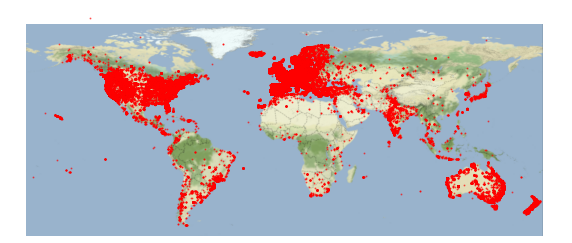

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
selection.plot(ax=ax, alpha=0.5, markersize=1, color="red")
ctx.add_basemap(ax, zoom=3, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), crs="epsg:4326")
plt.axis("off")
plt.show()

# Subselection by countries

In [96]:
### a classic example with world countries

url = "https://datahub.io/core/geo-countries/r/countries.geojson"
countries = geopandas.read_file(url)
countries.head(10)

,ADMIN,ISO_A3,geometry
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993..."
5,Aland,ALA,"MULTIPOLYGON (((20.92018 59.90925, 20.91236 59..."
6,Andorra,AND,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ..."
7,United Arab Emirates,ARE,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24..."
8,Argentina,ARG,"MULTIPOLYGON (((-68.65412 -54.88624, -68.65414..."
9,Armenia,ARM,"MULTIPOLYGON (((45.54717 40.62155, 45.51369 40..."


In [98]:
print(countries["ISO_A3"].tolist())

['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'ALA', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATA', '-99', 'ATF', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', '-99', 'BLM', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', '-99', 'CMR', '-99', 'COD', 'COG', 'COK', 'COL', 'COM', 'CPV', 'CRI', '-99', 'CUB', 'CUW', 'CYM', '-99', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', '-99', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUM', 'GUY', 'HKG', 'HMD', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IMN', 'IND', '-99', 'IOT', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', '-99', '-99', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', '-99', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAF', 'MAR', 'MCO'

In [115]:
countries[countries["ISO_A3"]=="DNK"]

,ADMIN,ISO_A3,geometry
64,Denmark,DNK,"MULTIPOLYGON (((11.25603 54.95458, 11.30348 54..."


In [100]:
def get_polygon(country_code):
    return countries[countries["ISO_A3"]==country_code]["geometry"].values[0]

In [116]:
selection = posts_gdf[posts_gdf["geometry"].within(get_polygon("DNK"))]
selection

,end_cursor,url,text,hashtags,caption,likes,location_slug,country_code,g_loc_type,timestamp,i_loc_type,country_code_new,country,region,subregion,geometry
88,QVFBS0R3Q09EWWNXMnk3aElRd2JwcWNpa192UmdFY0xman...,https://www.instagram.com/p/CEWqCldpi-J/,Nobody here but me #ilovemycampervan #vanlife...,"[ilovemycampervan, vanlife, nature, getoutside...","[one or more people, people standing, ocean, s...",2,vejers-strand-ribe-denmark,DK,"[campground, establishment, lodging, park, poi...",2020-08-26 13:21:42,city,DNK,Denmark,Europe,Northern Europe,POINT (8.13556 55.61933)
1076,QVFDM280TTRBMThpTWdYQlpOQTg5OG5UVFZsLVh6blc1dE...,https://www.instagram.com/p/CEWZ_kLg-R4/,This view is breathtaking! Cant believe this i...,[denmark#anighttoremember#roadtrip#sheisnotlos...,"[ocean, sky, plant, tree, outdoor, nature, wat...",24,mns-klint-denmark,NO,"[establishment, natural_feature, park, point_o...",2020-08-26 11:01:28,None,NOR,Norway,Europe,Northern Europe,POINT (12.54370 54.98413)
1159,QVFCVnhWR1l4QXRxbzdHMzFtZUtUZWRTeFJyUEdfanZTTG...,https://www.instagram.com/p/CEWY75MJz9N/,Guten Morgen...... Kurz nach zwlf!!!! #happyho...,"[happyholidays, denmark🇩🇰, heilixaufreisen, th...",[],25,denmark,DK,"[country, political]",2020-08-26 10:52:14,country,DNK,Denmark,Europe,Northern Europe,POINT (9.50178 56.26392)
1546,QVFCcUJRUGdIeVB3VlVWYzQ3MnRCMzFRXzh1ZG9tYThlSV...,https://www.instagram.com/p/CEWSV_3hvzQ/,Schiff Ahoi...#grisuontour#byebyedenmark#vanli...,[],[outdoor.],8,bjden-fynshav-frgen,DK,"[locality, political]",2020-08-26 09:54:38,None,DNK,Denmark,Europe,Northern Europe,POINT (9.98123 54.98779)
1959,QVFCNnVSQV9DakVGd2ZZa01EeDFTUEFNYU43c0xpSk9lQV...,https://www.instagram.com/p/CEWL0LdAcVq/,Es kommt wirklich immer so wie es kommen soll....,"[vanlife, roadtripdenmark, visitdenmark]","[1 person, sky, cloud, outdoor, nature.]",3911,skagen,DK,"[locality, political]",2020-08-26 08:57:35,city,DNK,Denmark,Europe,Northern Europe,POINT (10.57919 57.72500)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,QVFEa1lVVk9nYU1Yc3B0QTVHMkw0QUU5VThiX3BfbnZkNG...,https://www.instagram.com/p/CDYiAxvo5fI/,"#checkthisout Aufregung pur, was erwartet mi...","[checkthisout, vanlife, travelwithcats, livefo...","[sky, grass, outdoor, nature.]",66,fjaltring-ringkobing-denmark,DK,"[locality, political]",2020-08-02 12:18:38,city,DNK,Denmark,Europe,Northern Europe,POINT (8.13986 56.47442)
2758,QVFEa1lVVk9nYU1Yc3B0QTVHMkw0QUU5VThiX3BfbnZkNG...,https://www.instagram.com/p/CDYiAFZAm8n/,Spontan sein! Den Bus packen und einfach los f...,"[vanlife, vanlifegermany, vwt5camper, bullilov...","[1 person, standing, sky, outdoor, nature.]",136,hvide-sande-ringkobing-denmark,DK,"[locality, political]",2020-08-02 12:18:32,city,DNK,Denmark,Europe,Northern Europe,POINT (8.12793 56.01179)
2823,QVFEa1lVVk9nYU1Yc3B0QTVHMkw0QUU5VThiX3BfbnZkNG...,https://www.instagram.com/p/CDRnuEgh2s6/,LAUNDRY DAY #vanlife #homeonwheels #roadtr...,"[vanlife, homeonwheels, roadtrip, uvirkelig, l...","[sky, cloud, outdoor, nature.]",55,vesterhavet-blavand,DK,"[locality, political]",2020-07-30 19:53:49,None,DNK,Denmark,Europe,Northern Europe,POINT (8.18023 55.56290)
2824,QVFEa1lVVk9nYU1Yc3B0QTVHMkw0QUU5VThiX3BfbnZkNG...,https://www.instagram.com/p/CDM2CByBUuX/,#vanlife #homeonwheels #roadtrip #uvirkeli...,"[vanlife, homeonwheels, roadtrip, uvirkelig, l...","[1 person, eyeglasses, closeup.]",42,langeland,,"[establishment, natural_feature]",2020-07-28 23:22:40,None,,,,,POINT (10.70510 54.81994)


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

The "url" option is deprecated. Please use the "source" argument instead.



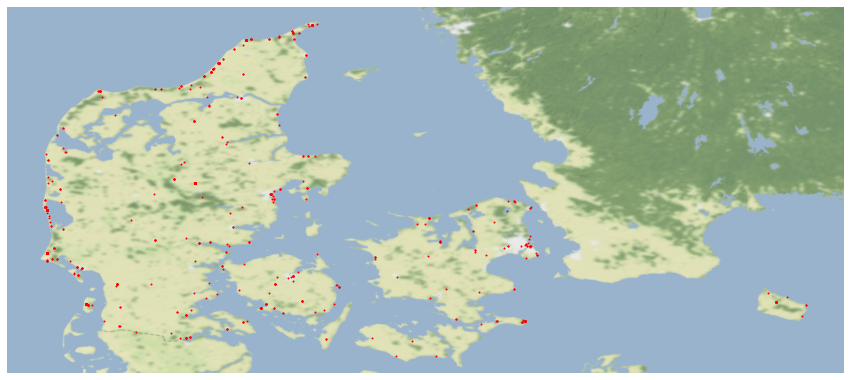

In [117]:
fig, ax = plt.subplots(figsize=(15,10))
selection.plot(ax=ax, alpha=1, markersize=1, color="red")
ctx.add_basemap(ax, zoom=8, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), crs="epsg:4326")
plt.axis("off")
plt.show()

# Interactive colormaps with plotly

In [87]:
!pip install plotly
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

import IPython

### to use plotly within browser notebook

def configure_plotly_browser_state():
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
help(plotly.offline.plot)

Help on function plot in module plotly.offline.offline:

plot(figure_or_data, show_link=False, link_text='Export to plot.ly', validate=True, output_type='file', include_plotlyjs=True, filename='temp-plot.html', auto_open=True, image=None, image_filename='plot_image', image_width=800, image_height=600, config=None, include_mathjax=False)
    Create a plotly graph locally as an HTML document or string.
    
    Example:
    ```
    from plotly.offline import plot
    import plotly.graph_objs as go
    
    plot([go.Scatter(x=[1, 2, 3], y=[3, 2, 6])], filename='my-graph.html')
    # We can also download an image of the plot by setting the image parameter
    # to the image format we want
    plot([go.Scatter(x=[1, 2, 3], y=[3, 2, 6])], filename='my-graph.html'
         image='jpeg')
    ```
    More examples below.
    
    figure_or_data -- a plotly.graph_objs.Figure or plotly.graph_objs.Data or
                      dict or list that describes a Plotly graph.
                      See h

# Tag Frequencies & Population & GDP

In [75]:
countries_tag_df = pd.DataFrame(posts_gdf.groupby("country_code").size())
countries_tag_df.reset_index(inplace=True)
countries_tag_df.columns = ["country_code", "tag_frequency"]
countries_tag_df.head(10)

,country_code,tag_frequency
0,,12586
1,AD,82
2,AE,54
3,AF,1
4,AL,50
5,AM,4
6,AR,381
7,AT,1687
8,AU,5795
9,AW,4


In [83]:
# to use 3-letter version of country codes
# we have to upload some normalized country codes data

country_codes_variants = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
country_codes_variants.set_index("alpha-2", inplace=True)
country_codes_variants.sort_values("alpha-3").head(10)

,name,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
alpha-2,,,,,,,,,,
AW,Aruba,ABW,533,ISO 3166-2:AW,Americas,Latin America and the Caribbean,Caribbean,19.0,419.0,29.0
AF,Afghanistan,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
AO,Angola,AGO,24,ISO 3166-2:AO,Africa,Sub-Saharan Africa,Middle Africa,2.0,202.0,17.0
AI,Anguilla,AIA,660,ISO 3166-2:AI,Americas,Latin America and the Caribbean,Caribbean,19.0,419.0,29.0
AX,Åland Islands,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
AL,Albania,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
AD,Andorra,AND,20,ISO 3166-2:AD,Europe,Southern Europe,NaN,150.0,39.0,NaN
AE,United Arab Emirates,ARE,784,ISO 3166-2:AE,Asia,Western Asia,NaN,142.0,145.0,NaN
AR,Argentina,ARG,32,ISO 3166-2:AR,Americas,Latin America and the Caribbean,South America,19.0,419.0,5.0


In [80]:
world_population_df = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
world_population_df.head(2)
world_population_2016_df = world_population_df[world_population_df["Year"]==2016]
world_population_2016_df.set_index("Country Code", inplace=True)
world_population_2016_df.sort_values("Country Code").head(10)

,Country Name,Year,Value
Country Code,,,
ABW,Aruba,2016,104872
AFG,Afghanistan,2016,35383128
AGO,Angola,2016,28842484
ALB,Albania,2016,2876101
AND,Andorra,2016,77297
ARB,Arab World,2016,404024433
ARE,United Arab Emirates,2016,9360980
ARG,Argentina,2016,43590368
ARM,Armenia,2016,2936146


In [84]:
### add the 3-letters version and country names into our dataset

def three_letters_abbr_returner(abbr):
  try: return country_codes_variants.at[abbr, "alpha-3"]
  except: return abbr

def country_name_returner(abbr):
  try: return country_codes_variants.at[abbr, "name"]
  except: return ""
  
def population_value_returner(abbr):
  try: return world_population_2016_df.at[abbr, "Value"]
  except: return ""
  
def tag_frequency_normalized(row_data):
  try: return float(float(row_data["tag_frequency"]) / float(row_data["population"]))
  except: return 0
  
countries_tag_df["country_code_new"] = countries_tag_df.apply(lambda row: three_letters_abbr_returner(row["country_code"]), axis=1)
countries_tag_df["country"] = countries_tag_df.apply(lambda row: country_name_returner(row["country_code"]), axis=1)
countries_tag_df["population"] = countries_tag_df.apply(lambda row: population_value_returner(row["country_code_new"]), axis=1)
countries_tag_df["tag_frequency_normalized"] = countries_tag_df.apply(lambda row: tag_frequency_normalized(row), axis=1)

countries_tag_df.head(5)

,country_code,tag_frequency,country_code_new,country,population,tag_frequency_normalized
0,,12586,,,,0.000000e+00
1,AD,82,AND,Andorra,77297,1.060843e-03
2,AE,54,ARE,United Arab Emirates,9360980,5.768627e-06
3,AF,1,AFG,Afghanistan,35383128,2.826206e-08
4,AL,50,ALB,Albania,2876101,1.738465e-05


In [92]:
configure_plotly_browser_state()

# based on this: https://plot.ly/python/choropleth-maps/

data = [go.Choropleth(
    locations = countries_tag_df['country_code_new'],
    z = countries_tag_df["tag_frequency"],
    text = countries_tag_df['country'],
    colorscale = [
        [0, "rgb(5, 10, 172)"],
        [0.35, "rgb(40, 60, 190)"],
        [0.5, "rgb(70, 100, 245)"],
        [0.6, "rgb(90, 120, 245)"],
        [0.7, "rgb(106, 137, 247)"],
        [1, "rgb(220, 220, 220)"]
    ],
    autocolorscale = True,
    reversescale = False,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(180,180,180)',
            width = 0.5
        )),
    colorbar = go.choropleth.ColorBar(
        tickprefix = 'N=',
        title = 'posts'),
)]

layout = go.Layout(
    title = go.layout.Title(
        text = '#vanlife - Summer 2020'
    ),
    geo = go.layout.Geo(
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        showframe = False,
        showcoastlines = True,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    ),
    annotations = [go.layout.Annotation(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = 'Data mined from Instagram',
        showarrow = False
    )]
)

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'd3-world-map')

In [90]:
configure_plotly_browser_state()

# based on this: https://plot.ly/python/choropleth-maps/

data = [go.Choropleth(
    locations = countries_tag_df['country_code_new'],
    z = countries_tag_df["tag_frequency_normalized"],
    text = countries_tag_df['country'],
    colorscale = [
        [0, "rgb(5, 10, 172)"],
        [0.35, "rgb(40, 60, 190)"],
        [0.5, "rgb(70, 100, 245)"],
        [0.6, "rgb(90, 120, 245)"],
        [0.7, "rgb(106, 137, 247)"],
        [1, "rgb(220, 220, 220)"]
    ],
    autocolorscale = True,
    reversescale = False,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(180,180,180)',
            width = 0.5
        )),
    colorbar = go.choropleth.ColorBar(
        tickprefix = 'N=',
        title = 'posts'),
)]

layout = go.Layout(
    title = go.layout.Title(
        text = '#vanlife/country population - Summer 2020'
    ),
    geo = go.layout.Geo(
        showframe = False,
        showcoastlines = False,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    ),
    annotations = [go.layout.Annotation(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = 'Data mined from Instagram',
        showarrow = False
    )]
)

fig = go.Figure(data = data, layout = layout)
iplot(fig, filename = 'd3-world-map')